In [1]:
from colorsys import hls_to_rgb

import jax as jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from jax.numpy import pi

import chromatix.functional as cx
from chromatix import shift_field
from chromatix.utils import siemens_star

In [2]:
# CC nadapez: from https://stackoverflow.com/a/20958684
def colorize(field, normalize=True, gamma=0.3):
    z = field.u
    r = np.abs(z)
    if normalize:
        r = r / np.max(r)

    arg = np.angle(z)

    hue = (arg + pi) / (2 * pi) + 0.5
    lightness = 1.0 - 1.0 / (1.0 + r**gamma)
    saturation = 0.8

    c = np.vectorize(hls_to_rgb)(hue, lightness, saturation)  # --> tuple
    c = np.array(c)  # -->  array of (3,n,m) shape, but need (n,m,3)
    c = c.swapaxes(0, 2)
    c = c.swapaxes(0, 1)
    return c

## Scalable Angular Spectrum (SAS) propagation applied to a Gabor inline hologram

A scattering sample (here a rectangular aperture) is illuminated by a spherically expanding wave and the diffraction pattern is recorded at a distant detector

In [3]:
N_box = 512  # sampling points along the width
L_box = 128  # width of the initial field to calculate on in µm
source_distance = 200.0  # distance of the source from the sample
detector_distance = 5000.0  # distance of the detector from the sample
lbd = 0.5
shape = (N_box, N_box)
kx = 2 * jnp.pi / lbd * np.sin(20 / 360 * 2 * jnp.pi)

field_sample = cx.point_source(
    shape=shape,
    dx=L_box / N_box,
    spectrum=lbd,
    z=source_distance,
    n=1.0,
)
# field_sample = cx.plane_wave(shape=shape, dx=L_box/N_box, spectrum=lbd, spectral_density=1.0, kykx=[0,kx]) / 0.0078125

D_box = L_box / 16

# field_exit = cx.square_pupil(field_sample, w=D_box)
star = siemens_star(field_sample.spatial_shape[0], num_spokes=16, radius=[120, 150])
field_exit = field_sample * jnp.array(star)
field_exit = shift_field(field_exit, (-80, 50))
# field_exit = cx.shift_ft(field_exit, (30.5, 0))

field_sensor = cx.propagation.transform_propagate_sas(
    field_exit, z=detector_distance, n=1.0, skip_final_phase=True
)

field_sensor_fr = cx.propagation.transform_propagate(
    field_exit, z=detector_distance, n=1.0, pad_width=(256, 256), skip_final_phase=True
)

## This is our source field to propagate

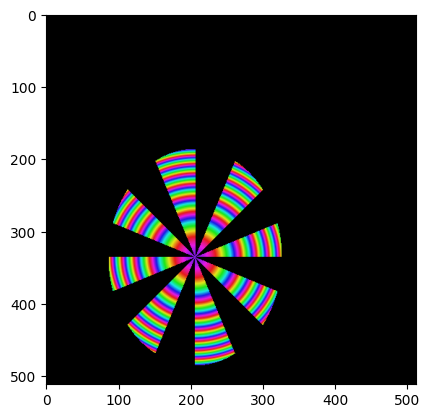

In [4]:
plt.imshow(colorize(field_exit))

## Here is the field at the detector

(512, 512)
[9.765625 9.765625]


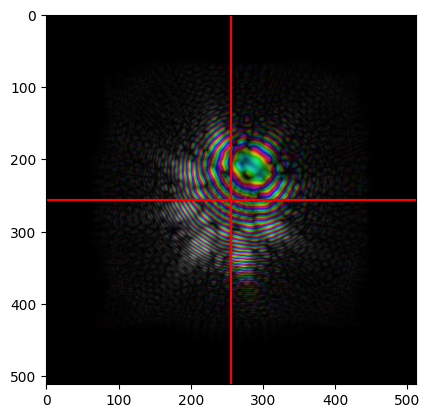

In [5]:
print(field_sensor.u.shape)
print(np.squeeze(field_sensor.dx))
plt.imshow(colorize(field_sensor, gamma=1.0))
plt.axvline(256, color="r")
plt.axhline(256, color="r")

## Detector Field back-propagated to the source ccordinates

[0.25 0.25]


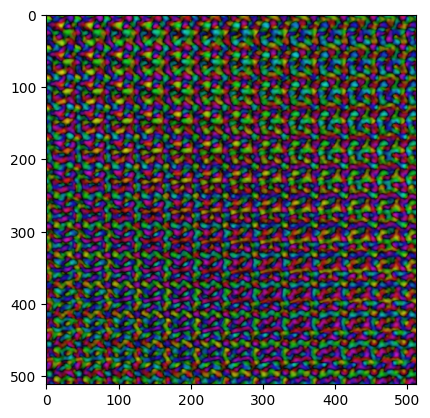

In [6]:
# inverse SAS

field_backpropagated = cx.propagation.transform_propagate_sas(
    field_sensor, z=-detector_distance, n=1.0, skip_initial_phase=False
)
print(np.squeeze(field_backpropagated.dx))
plt.imshow(colorize(field_backpropagated, gamma=1.0))

## Fresnel forward propagated field can also be back-propagated, but the forward propagation is not physically correct

1.7185339
1.7446291
1.7185333


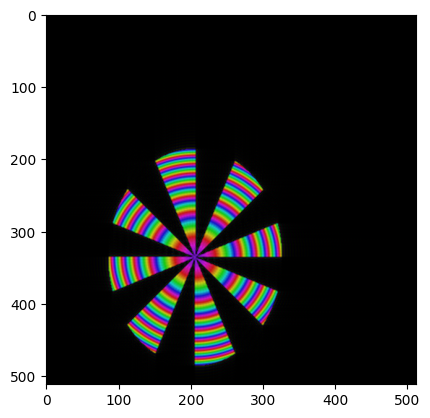

In [7]:
# inverse Fresnel
field_bwd = cx.propagation.transform_propagate(
    field_sensor_fr,
    z=-detector_distance,
    n=1.0,
    pad_width=(256, 256),
    skip_initial_phase=True,
)
plt.imshow(colorize(field_bwd, gamma=1.0))
# lets check for integral intensities
print(np.sum(field_bwd.intensity))
print(np.sum(field_exit.intensity))
print(
    np.sum(
        abs(
            cx.ifft(
                cx.fft(field_bwd.u, axes=field_bwd.spatial_dims),
                axes=field_bwd.spatial_dims,
            )
        )
        ** 2
    )
)

a = np.random.rand(10, 10)
# print(cx.conditional_fft(a, 1, 1))

## Detector field, backpropagated via Fresnel propagation yield bad results 

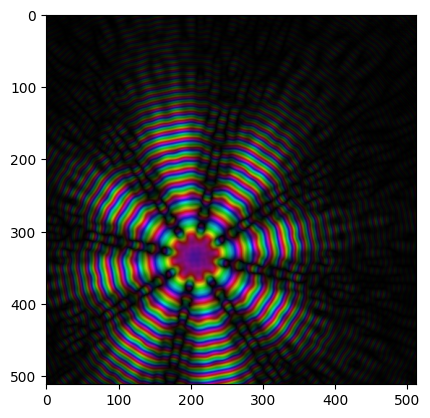

In [8]:
# inverse Fresnel on sas propagated field
field_bwd = cx.propagation.transform_propagate(
    field_sensor,
    z=-detector_distance,
    n=1.0,
    pad_width=(256, 256),
    skip_initial_phase=True,
)
plt.imshow(colorize(field_bwd, gamma=1.0))